### Measuring Information Detail - Name Entity Recognition

We can quanitfy how "rich" or "detailed" commentary is with NER using SpaCy.  With more references to entities, such as people, teams, players, locations, etc, the commentary is then more details and rich with information.

The spaCy model ("en_core_web_sm") is a pre-trained NLP model that includes a Name Entity Recognition component trained on a giant corpora.  The model can recognizes names, things, organizations, places, and more.

1) Proxy Detail: more references to specific entities suggest the commentator is supplying the viewers with more detail and information about these entities.
2) Differentiating Information: a greater quantity of entities mentioned shows a wider array of subjects and information of the commentator's announcing duties.
3) Quantitative Metrics: a 'detail score' could consist of the ratio of named-entities to the number of total tokens in transcript. This would lead us to suspect a higher ratio portrays a commentator with greater supply of detail in his/her game commentary.

In [39]:
# imports 
#!pip install spacy
#!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
nlp = spacy.load("en_core_web_sm")
data = pd.read_json("../dataset/preprocessed_data_full.json")


In [41]:
# Verify model installation
print(spacy.prefer_gpu())  # checks if GPU is available
print(model.pipe_names)      # Should include 'ner' in the output

True
['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [42]:
def calculate_entity_metrics(text):
    """
    Calculate entity-based metrics for a given text.
    """
    try:
        # Process the text with spaCy
        doc = nlp(str(text))
        
        # Count entities
        entities = list(doc.ents)
        total_tokens = len(doc)
        
        # Calculate metrics
        entity_count = len(entities)
        entity_density = entity_count / total_tokens if total_tokens > 0 else 0
        
        # Count entity types
        entity_types = {}
        for ent in entities:
            entity_types[ent.label_] = entity_types.get(ent.label_, 0) + 1
            
        return {
            'entity_count': entity_count,
            'entity_density': entity_density,
            'total_tokens': total_tokens,
            'entity_types': entity_types,
            'unique_entities': len(set(ent.text.lower() for ent in entities))
        }
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return None

In [43]:
def analyze_information_density(data):
    """
    load model and apply to all games
    """
    results = []
    
    print("Processing transcripts...")
    for idx, row in tqdm(data.iterrows(), total=len(data)):
        try:
            # Calculate metrics for this transcript
            metrics = calculate_entity_metrics(row['transcript'])
            
            if metrics:
                result = {
                    'game_id': row['game_id'],
                    'year': row['year'],
                    'broadcaster': row['broadcaster'],
                    **metrics
                }
                results.append(result)
                
        except Exception as e:
            print(f"Error processing game {row['game_id']}: {str(e)}")
    
    return pd.DataFrame(results)

In [44]:
def plot_information_density_analysis(results_df):
    """
    Create visualizations for information density analysis.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Entity density by broadcaster
    sns.boxplot(data=results_df, x='broadcaster', y='entity_density', ax=axes[0,0])
    axes[0,0].set_title('Entity Density Distribution by Broadcaster')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # 3. Average entity count by broadcaster
    results_df.groupby('broadcaster')['entity_count'].mean().plot(
        kind='bar', ax=axes[1,0], color='darkturquoise')
    axes[1,0].set_title('Average Entity Count by Broadcaster')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    
    # 4. Unique entities vs total entities
    sns.scatterplot(data=results_df, x='entity_count', y='unique_entities',
                    hue='broadcaster', alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title('Unique Entities vs Total Entities')
    
    plt.tight_layout()
    plt.show()

In [45]:
results = analyze_information_density(data)
# Print summary statistics
print("\nSummary Statistics:")
print(f"Average Entity Density: {results['entity_density'].mean():.3f}")
print(f"Average Unique Entities: {results['unique_entities'].mean():.1f}")
print("\nEntity Density by Broadcaster:")
print(results.groupby('broadcaster')['entity_density'].mean().sort_values(ascending=False))

# Create visualizations
plot_information_density_analysis(results)

Processing transcripts...


  0%|          | 1/1216 [00:04<1:29:27,  4.42s/it]


KeyboardInterrupt: 

/var/folders/3n/cwnbs7r54tg9sdh6j221x5z80000gn/T/ipykernel_63939/3937338877.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)


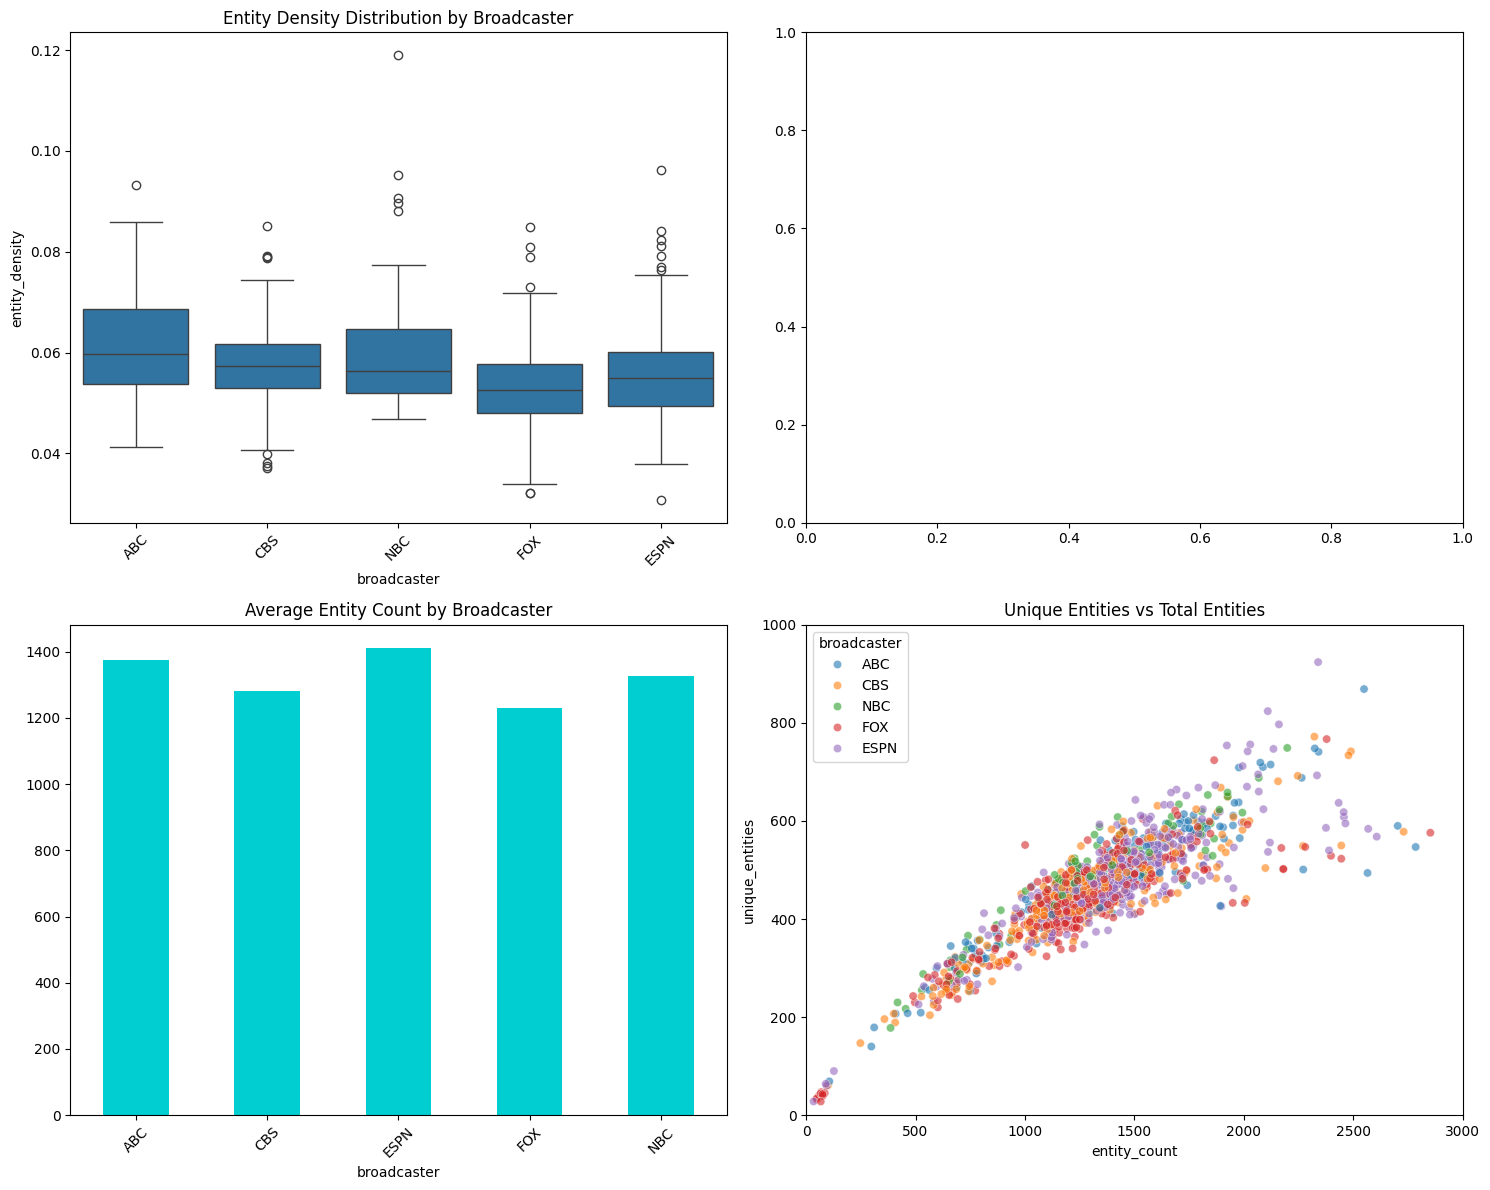

In [37]:
def plot_information_density_analysis(results_df):
    """
    Create visualizations for information density analysis.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Entity density by broadcaster
    sns.boxplot(data=results_df, x='broadcaster', y='entity_density', ax=axes[0,0])
    axes[0,0].set_title('Entity Density Distribution by Broadcaster')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # 3. Average entity count by broadcaster
    results_df.groupby('broadcaster')['entity_count'].mean().plot(
        kind='bar', ax=axes[1,0], color='darkturquoise')
    axes[1,0].set_title('Average Entity Count by Broadcaster')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    
    # 4. Unique entities vs total entities
    sns.scatterplot(data=results_df, x='entity_count', y='unique_entities',
                    hue='broadcaster', alpha=0.6, ax=axes[1,1])
    axes[1,1].set_title('Unique Entities vs Total Entities')
    axes[1,1].set_xlim(0, 3000)
    axes[1,1].set_ylim(0, 1000)
    plt.tight_layout()
    plt.show()

plot_information_density_analysis(results)

In [38]:
import json
import os

# Create a dictionary with the formatted results for export
export_data = {
    broadcaster: {
        "average_entity_density": float(group["entity_density"].mean()),
        "average_unique_entities": float(group["unique_entities"].mean()),
        "average_entity_count": float(group["entity_count"].mean()),
        "num_broadcasts": int(len(group))
    }
    for broadcaster, group in results.groupby('broadcaster')
}

# Define the output directory and filename
output_dir = "test_results"
output_file = os.path.join(output_dir, "information_density_results.json")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Export to JSON file
with open(output_file, 'w') as f:
    json.dump(export_data, f, indent=4)

print(f"Information density results exported to {output_file}")



Information density results exported to test_results/information_density_results.json
